In [2]:
library(gtools)
library(dplyr)
library(ggplot2)

In [3]:
# load data
inTeams<-read.csv("https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv")

In [4]:
# PRE SIMULATION WORK

In [5]:
# Prize dataframe
ranks <- 1:20
prizes <- matrix(ranks, nrow=20, ncol=1, byrow=FALSE)
prizes <- as.data.frame(prizes)
colnames(prizes) <- c('team_rank')
prizes$prize <- c(225,210,200,190,160,150,140,125,123,120,118,115,112,110,108,105,100,52,50,49)

In [6]:
# taking averages
mean.off<-mean(inTeams$off)
mean.def<-mean(inTeams$def)
lmean.off<-mean(log(inTeams$off))
lmean.def<-mean(log(inTeams$def)) 

# subset to premier league
premLeague<-subset(inTeams,league=="Barclays Premier League")
premTeams<-premLeague$name
rownames(premLeague)<-premTeams
df.prem<-premLeague[,c("off","def")]

# build parameters
lmean.def<- log(mean(df.prem$def))
lmean.off<- log(mean(df.prem$off))               
df.prem["alpha"]<-log(df.prem["off"])-lmean.def
df.prem["delta"]<-lmean.off-log(df.prem["def"])
alphaList<-df.prem$alpha
deltaList<-df.prem$delta
names(alphaList)<-rownames(df.prem)
names(deltaList)<-rownames(df.prem)

In [7]:
# simulate score line for a match
draw.score<-function(team1,team2){
    c(
        rpois(1,exp(alphaList[team1]-deltaList[team2])),
  rpois(1,exp(alphaList[team2]-deltaList[team1]))
    )
}
draw.score("Liverpool","Arsenal")

[1] 2 0

In [8]:
# All possible matches in a season
allMatches<-permutations(20, 2, v=rownames(df.prem),repeats.allowed=FALSE)
colnames(allMatches)<-c("home","away")
allMatches
nrow(allMatches)

home,away
Arsenal,Aston Villa
Arsenal,Brentford
Arsenal,Brighton and Hove Albion
Arsenal,Burnley
Arsenal,Chelsea
Arsenal,Crystal Palace
Arsenal,Everton
Arsenal,Leeds United
Arsenal,Leicester City
Arsenal,Liverpool


[1] 380

In [9]:
# SIMULATION

In [10]:
SeasonSim <- function(allMatches){
     ScoresMatrix <- matrix(nrow=nrow(allMatches),  ncol=4)
        for (ii in 1:nrow(allMatches)  ) {
         ScoresMatrix[ii,1:2]=allMatches[ii,]
         ScoresMatrix[ii,3:4]= as.numeric(draw.score(allMatches[ii,"home"],allMatches[ii,"away"] ))
        }
        colnames(ScoresMatrix)<-c("home.team","away.team","home.score","away.score")
        ScoresMatrix <- as.data.frame(ScoresMatrix)
        ScoresMatrix$home.score <- as.numeric(ScoresMatrix$home.score)
        ScoresMatrix$away.score <- as.numeric(ScoresMatrix$away.score)  
        
        # PEPARING AGGREGATE STATS DFs
        df.points <- as.data.frame(ScoresMatrix)
        df.points_goalsfor <- as.data.frame(ScoresMatrix)
        df.points_goalsagainst <- as.data.frame(ScoresMatrix)
        name <- rownames(df.prem)
        for (i in 1:20){
            df.points[, name[i]] <- 0
        }
        df.points

        # ASSIGNING POINTS PER MATCH
        for (i in 1:380){ 
            for (j in 1:20){
                if (df.points[i,1] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 3
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 0
                    } 
                } 
                if (df.points[i,2] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 0
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 3
                    }      
                }
            }   
        } 
    
        # PREPARING DFs
        for (i in 1:20){
            df.points_goalsfor[, name[i]] <- 0
        }
        for (i in 1:20){
            df.points_goalsagainst[, name[i]] <- 0
        }
    
        # GOALS FOR
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsfor[i,1] == name[j]){ # looking at home team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,3]  # home points go to goals for
                }
                if (df.points_goalsfor[i,2] == name[j]){ # looking at away team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,4] # away points go to goals for
                }
            }
        }
    
        # GOALS AGAINST
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsagainst[i,1] == name[j]){ # looking at home team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,4]  # home points go to goals for
                }
                if (df.points_goalsagainst[i,2] == name[j]){ # looking at away team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,3] # away points go to goals for
                }
            }
        } 
        
        # AGGREGATING POINTS and GOALS
        points <- df.points[,c(-1,-2,-3,-4)]
        points <- sapply(points, as.numeric)
        points_sum <- as.data.frame(colSums(points))
        
        goalsfor <- df.points_goalsfor[,c(-1,-2,-3,-4)]
        goalsfor <- sapply(goalsfor, as.numeric)
        goalsfor_sum <- as.data.frame(colSums(goalsfor))
    
        goalsagainst <- df.points_goalsagainst[,c(-1,-2,-3,-4)]
        goalsagainst <- sapply(goalsagainst, as.numeric)
        goalsagainst_sum <- as.data.frame(colSums(goalsagainst))

        # MERGE TO ONE DF
        df.teams <- cbind(points_sum, goalsfor_sum, goalsagainst_sum)
        colnames(df.teams)[1] <- 'points'
        colnames(df.teams)[2] <- 'goals_for'
        colnames(df.teams)[3] <- 'goals_against'
        df.teams$team_names <- row.names(df.teams)
    
        # ADD TIE BREAKER VARIABLES
        df.teams <- df.teams %>%
            mutate(net_goals = goals_for - goals_against) %>%
            mutate(tie_breaker = runif(20, 0, 1))
        df.teams1 <- df.teams
        df.teams1$temp_team_rank <- rank(desc(df.teams1$points))
        df.teams1$temp_team_rank2 <- rank(desc(df.teams1$points))
        df.teams1$goals_rank <- rank(desc(df.teams1$net_goals))
        df.teams1$goalsfor_rank <- rank(desc(df.teams1$goals_for))
        df.teams1
    
        # RANK 
        for (ii in 1:nrow(df.teams1)){
            for (jj in 1:nrow(df.teams1)){
                if (ii != jj & df.teams1[ii,7] == df.teams1[jj,7]){
                    if (df.teams1[ii,9] > df.teams1[jj,9]){ #goals rank
                        df.teams1[ii,8] = df.teams1[ii,8]+0.5
                        df.teams1[jj,8] = df.teams1[jj,8]-0.5
                    } else if (df.teams1[ii,9] == df.teams1[jj,9]){ 
                        if (df.teams1[ii,10] > df.teams1[jj,10]){ #goals_for rank
                            df.teams1[ii,8] = df.teams1[ii,8]+0.5
                            df.teams1[jj,8] = df.teams1[jj,8]-0.5
                        } else if (df.teams1[ii,10] == df.teams1[jj,10]){                   
                            if (df.teams1[ii,6] > df.teams1[jj,6]){
                            df.teams1[ii,8] = df.teams1[ii,8]+0.5
                            df.teams1[jj,8] = df.teams1[jj,8]-0.5
                            }   
                        }
                    }
                }
            }
        }
        df.teams1$team_rank <- rank(df.teams1$temp_team_rank2)
        
         # ASSIGN PRIZE
        df.earnings <- left_join(df.teams1, prizes, by=c("team_rank"))
        df.earnings
    }

SeasonSim(allMatches)

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
83,64,14,Manchester City,50,0.10805510,2.0,2,1.0,1.0,2,210
85,62,17,Liverpool,45,0.31870896,1.0,1,2.0,2.0,1,225
74,45,12,Chelsea,33,0.09044425,3.0,3,3.0,4.5,3,200
61,50,31,Arsenal,19,0.44961377,4.5,4,4.0,3.0,4,190
56,42,32,Tottenham Hotspur,10,0.70465730,7.5,7,6.0,7.5,7,140
58,45,32,Manchester United,13,0.93348140,6.0,6,5.0,4.5,6,150
55,35,32,Aston Villa,3,0.51002890,9.0,9,11.0,13.0,9,123
54,35,31,West Ham United,4,0.09497463,11.0,11,10.0,13.0,11,118
54,39,31,Brighton and Hove Albion,8,0.69718880,11.0,10,8.5,9.5,10,120


In [11]:
# results df
finalcol <- c("points", "goals_for", "goals_against", "team_names", "net_goals", "tie_breaker", "team_rank", "goals_rank", "goalsfor_rank", "prize")
df.final.output <- as.data.frame(matrix(ncol = length(finalcol), nrow=0, dimnames = list(NULL,finalcol)))

# simulations
nsims <- 100

# simulation
for (rep in 1:nsims) {
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$sim <- rep
    df.final.output <- rbind(df.final.output, df.sim.earnings)
}
df.final.output

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,sim
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
88,60,7,Manchester City,53,0.10230445,2.0,2,1.0,1.0,2,210,1
91,55,7,Liverpool,48,0.84875992,1.0,1,2.0,2.0,1,225,1
72,45,15,Chelsea,30,0.13370729,3.0,3,3.0,4.0,3,200,1
68,44,19,Arsenal,25,0.27705418,4.0,4,4.0,5.0,4,190,1
54,35,32,Tottenham Hotspur,3,0.24152241,7.5,8,8.0,11.5,8,125,1
45,33,34,Manchester United,-1,0.85328174,10.0,9,9.0,13.0,9,123,1
59,32,27,Aston Villa,5,0.20458574,5.0,5,6.5,14.5,5,160,1
54,39,34,West Ham United,5,0.54066534,7.5,7,6.5,8.0,7,140,1
44,26,31,Brighton and Hove Albion,-5,0.33872140,12.0,12,10.0,17.5,12,115,1


In [74]:
write.csv(df.final.output, "C:\\Users\\Kiersten\\Documents\\simulation.csv")

***ANALYSIS***
1. Assemble a ranking of the teams from best to worst according to their expected position in the table.
    Illustrate this ranking with a clear visualization
2. Which teams have the most variability in their simulated earnings?
    Again, illustrate this variability with a clear visualization.
3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)?
    Again provide a visualization of this marginal effect
4. Finally, for each team, calculate the monetary benefit to each team from either (i) an increase of 10% to their expected goals scored (holding everyone else constant), or (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team

***1. Teams by best to worst expected position***

In [12]:
head(df.final.output)
# taking averages
df.summary <- df.final.output %>%
    group_by(team_names) %>%
    mutate(avg_rank = mean(team_rank)) %>%
    mutate(avg_prize = mean(prize)) %>%
    mutate(variability = sd(team_rank)) # sqrt of the variance


df.analysis <- select(df.summary, c(4,14,15,16))
df.analysis = unique(df.analysis)
df.analysis



,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,sim
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,88,60,7,Manchester City,53,0.1023045,2.0,2,1,1.0,2,210,1
2,91,55,7,Liverpool,48,0.8487599,1.0,1,2,2.0,1,225,1
3,72,45,15,Chelsea,30,0.1337073,3.0,3,3,4.0,3,200,1
4,68,44,19,Arsenal,25,0.2770542,4.0,4,4,5.0,4,190,1
5,54,35,32,Tottenham Hotspur,3,0.2415224,7.5,8,8,11.5,8,125,1
6,45,33,34,Manchester United,-1,0.8532817,10.0,9,9,13.0,9,123,1


team_names,avg_rank,avg_prize,variability
<chr>,<dbl>,<dbl>,<dbl>
Manchester City,1.57,217.10,0.7142843
Liverpool,1.90,212.75,0.9045340
Chelsea,2.82,201.45,0.8572920
Arsenal,5.02,170.86,1.9642255
Tottenham Hotspur,6.31,154.19,2.5925106
Manchester United,7.94,139.28,2.9943381
Aston Villa,8.25,137.05,3.3131968
West Ham United,9.77,123.60,3.1522158
Brighton and Hove Albion,8.91,130.32,2.9579374


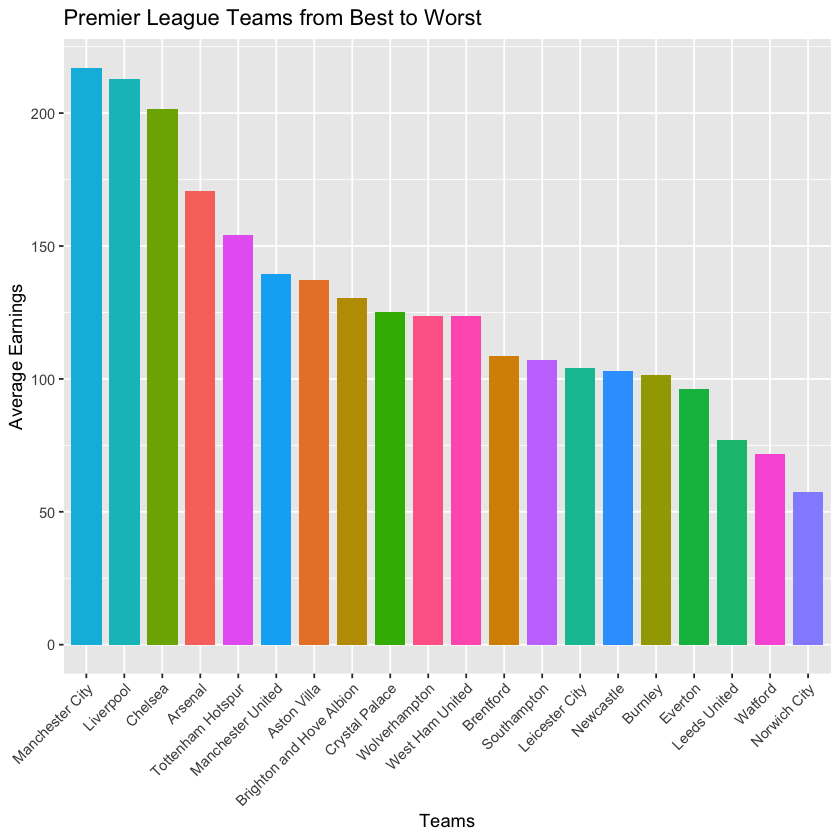

In [85]:
# Visualize rankings/earnings
ggplot(df.analysis, aes(x=reorder(team_names,-avg_prize), y=avg_prize, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Average Earnings') +
  ggtitle('Premier League Teams from Best to Worst') +
  theme(legend.position="none")

***2. Which teams have the most variability in their simulated earnings?***
South Hampton, West Ham United, Brentford (based off of sensitive measure of variability)

Visualizing the range of earnings per team:
Resistance measure (interquartile range)

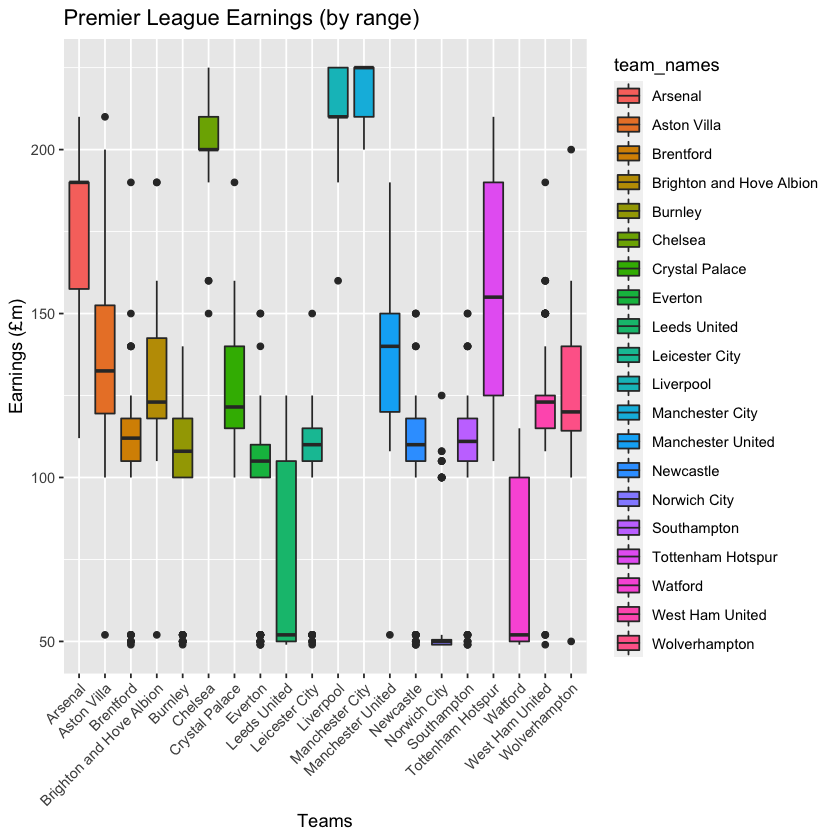

In [14]:
ggplot(df.summary, aes(x=team_names, y=prize, fill=team_names)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Earnings (£m)') +
    ggtitle('Premier League Earnings (by range)')

Standard deviation (sensitive measure):
Use given we won't have extreme outliers since our model doesn't account for shocks

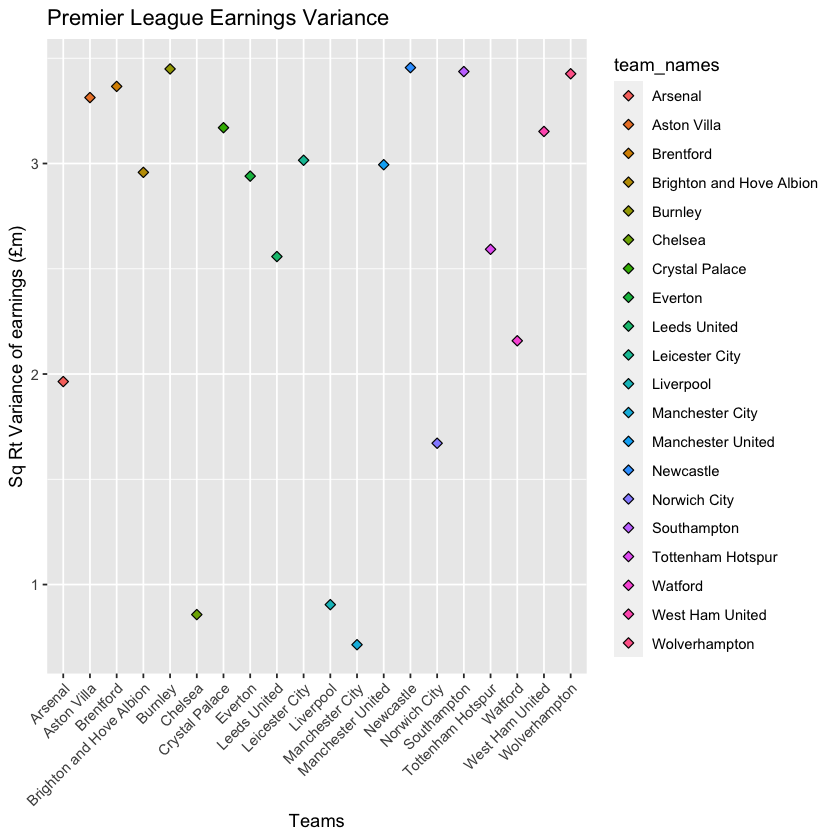

In [15]:
ggplot(df.analysis, aes(x=team_names, y=variability, fill=team_names)) +
  geom_point(size=2, shape=23) +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Sq Rt Variance of earnings (£m)') +
    ggtitle('Premier League Earnings Variance')

***3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)? (visualization of marginal effect)***

In [16]:
# clean appropriate variables
df.summary$prize <- as.numeric(df.summary$prize)
df.summary$points <- as.numeric(df.summary$points)
df.summary$goals_for <- as.numeric(df.summary$goals_for)
df.summary$goals_against <- as.numeric(df.summary$goals_against)
df.summary$net_goals <- as.numeric(df.summary$net_goals)
df.summary$tie_breaker <- as.numeric(df.summary$tie_breaker)
df.summary$team.f <- factor(df.summary$team_names)

reg1 <- lm(prize ~ points + team.f + team.f*points, data=df.summary) 
summary(reg1)


Call:
lm(formula = prize ~ points + team.f + team.f * points, data = df.summary)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.918  -6.515   0.266   7.161  40.886 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                           -20.081327  12.022959  -1.670 0.095030
points                                  2.978339   0.186556  15.965  < 2e-16
team.fAston Villa                       0.036970  14.777730   0.003 0.998004
team.fBrentford                         7.719672  14.407555   0.536 0.592153
team.fBrighton and Hove Albion         12.358255  15.894255   0.778 0.436940
team.fBurnley                           8.365396  13.946820   0.600 0.548704
team.fChelsea                         133.320001  18.313951   7.280 4.82e-13
team.fCrystal Palace                   35.279841  15.231192   2.316 0.020645
team.fEverton                         -11.797012  14.057764  -0.839 0.401470
team.fLeeds United                    -

In [79]:
points1 <- rep(3, 20)
newdata1 <- data.frame(points1)
names(newdata1)[names(newdata1) == 'points1'] <- 'points'
newdata1$team.f <- df.summary$team.f[1:20]
newdata1$prize <- predict(reg1, newdata1)

points2 <- rep(0, 20)
newdata2 <- data.frame(points2)
names(newdata2)[names(newdata2) == 'points2'] <- 'points'
newdata2$team.f <- df.summary$team.f[1:20]
newdata2$prize <- predict(reg1, newdata2)

newdata1$prize_change <- newdata1$prize - newdata2$prize

newdata1

points,team.f,prize,prize_change
<dbl>,<fct>,<dbl>,<dbl>
3,Manchester City,133.8528778,3.027902
3,Liverpool,107.6615293,3.962612
3,Chelsea,116.7266670,3.487992
3,Arsenal,-11.1463090,8.935018
3,Tottenham Hotspur,-42.3101539,10.373051
3,Manchester United,-23.6835653,9.306886
3,Aston Villa,-11.4708973,8.573460
3,West Ham United,-0.6732341,7.811014
3,Brighton and Hove Albion,0.1187994,7.841871


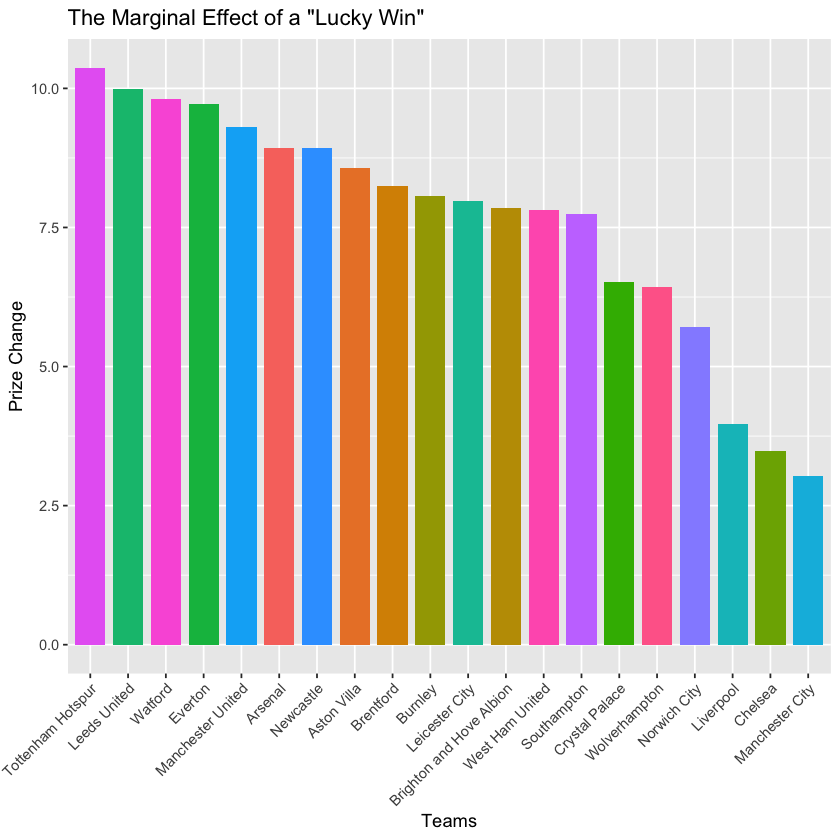

In [84]:
ggplot(newdata1, aes(x=reorder(team.f,-prize_change), y=prize_change, fill=team.f)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Prize Change') +
  ggtitle('The Marginal Effect of a "Lucky Win"') +
  theme(legend.position="none")

In [ ]:
# plot (not right code, just a template)
ggplot(dummy, aes(x=x, y=predicted)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), alpha = .9,position = position_dodge())+
  labs(
    x="Sex",
    y="Salary",
    title="The Marginal Effect of Sex on Salary"
  )+scale_x_continuous(breaks=c(1,2) ,labels = c("Female", "Male"))

***4. Finally, for each team, calculate the monetary benefit to each team from either 
    (i) an increase of 10% to their expected goals scored (holding everyone else constant), or 
    (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)***
    
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team